In [1]:
import pandas as pd
from shapely.geometry import Point
from shapely.ops import cascaded_union
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import requests
import os

In [2]:
COLORS = ["#16a085", "#2980b9", "#8e44ad", "#f39c12", "#c0392b", "#2c3e50", "#95a5a6"]
URL = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-04/water.csv"

In [3]:
def download_data(url, target="water.csv"):
    """Download input file from the web."""
    if not os.path.exists(target):
        r = requests.get(url, allow_redirects=True)
        open(target, 'wb').write(r.content)
        
def load_data(infile="water.csv"):
    return pd.read_csv(infile)
    
def shapefile_continent(continent="Africa"):
    """Get a single combined shapefile for a specified continent."""
    shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    valid_shapes = [record.geometry for record in reader.records() if record.attributes["CONTINENT"] == continent]
    
    return gpd.GeoSeries(cascaded_union(valid_shapes))

def filter_data(data, continent="Africa"):
    """Remove all data points that are not within the specified continent."""
    shapefile = shapefile_continent(continent=continent)
    mask = [shapefile.contains(Point(lon, lat)).bool() for lat, lon in zip(data["lat_deg"], data["lon_deg"])]
    return data[mask]

def harmonize_water_sources(data):
    """Replace water_source by more general attributes"""
    
    # Summarize all sources that appear only in few instances as others
    count = data.groupby("water_source").count()["row_id"]
    others = count[count < 0.01 * len(data)].index.tolist()
    
    data["water_source"] = data['water_source'].replace(others,'Other')
    data["water_source"] = data['water_source'].replace(['Protected Spring', 'Unprotected Spring', 'Undefined Spring'],'Spring')
    data["water_source"] = data['water_source'].replace(['Protected Shallow Well', 'Unprotected Shallow Well', 'Undefined Shallow Well'],'Shallow Well')
    data["water_source"] = data['water_source'].replace(['Surface Water (River/Stream/Lake/Pond/Dam)'],'Surface Water')
    data.water_source = data.water_source.fillna("Unknown")

    return data

In [5]:
# Load the data, filter out all points outside Africa and categorize the water sources
download_data(url=URL)
data = load_data()
data = filter_data(data)
data = harmonize_water_sources(data)

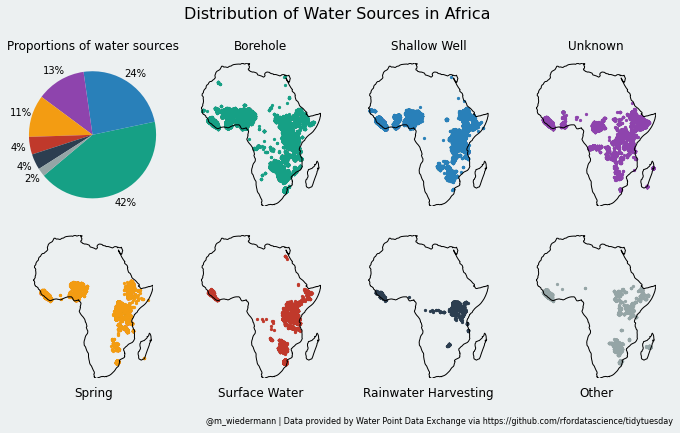

In [11]:
fig = plt.figure(figsize=(9.5, 6))

# Get the shapefile for Africa
shpfile = shapefile_continent(continent="Africa")

# Start by drawing a pie chart for the proportions of each water source
ax = fig.add_subplot(2,4,1, projection=ccrs.Robinson())
sources_count = data.groupby("water_source").count()["row_id"].sort_values(ascending=False)
cs = sources_count.plot.pie(colors=COLORS, ax=ax, labels=None, ylabel="", autopct='%1.0f%%', pctdistance=1.18, startangle=220)
ax.axis('equal')
ax.set_title("Proportions of water sources", y=1.05)

# Iterate over each source and draw its locations in unique color on separate maps
for i, (color, source) in enumerate(zip(COLORS, sources_count.index.to_list())): 

    ax = fig.add_subplot(2,4,i+2, projection=ccrs.Robinson())
    ax.set_extent([-21, 60, -40, 40], crs=ccrs.PlateCarree())
    
    x0, y0, x1, y1 = shpfile.bounds.loc[0].values
    ax.set_extent([x0, x1, y0, y1], crs=ccrs.PlateCarree())
    ax.add_geometries(shpfile, crs=ccrs.PlateCarree(), facecolor="None")
    ax.axis('off')
    
    x = data[data.water_source == source].lon_deg
    y = data[data.water_source == source].lat_deg
    ax.scatter(x=x, y=y, c=color, s=5, transform=ccrs.PlateCarree(), rasterized=True) 
    
    ax.set_title(source, y=1.05 if i < 3 else -0.17)

# Finalize the figure
plt.subplots_adjust(wspace=0.0, hspace=0.2, left=0.02, right=1, top=0.85, bottom=0.12)
fig.patch.set_facecolor('#ecf0f1')
plt.suptitle("Distribution of Water Sources in Africa", fontsize=16) 
fig.text(0.99, 0.015, "@m_wiedermann | Data provided by Water Point Data Exchange via https://github.com/rfordatascience/tidytuesday", ha="right", size=8)
plt.savefig("water_sources.jpg", dpi=500)
plt.show()